In [1]:
import random
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy import sparse
from tqdm import tqdm
from collections import Counter

In [2]:
train_pd = pd.read_csv("./data/train.csv", encoding="utf-8")

print("get word_list & vocab_list")
word_list = []
vocab_list = []
for line in tqdm(train_pd.value):
    word_list.append([w for w in line])
    vocab_list.extend([w for w in line])
    
print("get vocab")
c = Counter(vocab_list)
vocab = np.array(list(c.keys()))
vocab.sort()
print(vocab)

print("lable encoder vocab")
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(vocab)
print(label_encoder.classes_)
# label_encoder.transform(vocab)

print("label encoder word_list")
word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
word_size = [len(i) for i in word_labelencoder]

print("balanced pos & neg data")
train_size_pd = pd.DataFrame(word_size, columns=['len'])
train_size_pd['label'] = train_pd.label
# train_size_pd.describe()
train_size_pd = train_size_pd[train_size_pd.len < 500]
print(Counter(train_size_pd.label))

pos_index = train_size_pd[train_size_pd.label == 1].index.values
random.seed(8)
random.shuffle(pos_index)
print(pos_index, pos_index.shape)

neg_index = train_size_pd[train_size_pd.label == 0].index.values
neg_index = np.random.choice(neg_index, size=4000-1973)
print(neg_index, neg_index.shape)

balance_train_index = np.append(pos_index,neg_index)
random.shuffle(balance_train_index)
print(balance_train_index, balance_train_index.shape)

print("get data")
x_batch = np.array(word_labelencoder.copy())
x_batch = x_batch[balance_train_index]
y_batch = np.array(train_pd.label.copy())
y_batch = y_batch[balance_train_index]
x_batch_size = [len(i) for i in x_batch]
print(x_batch.shape, y_batch.shape, len(x_batch_size))

print("padding & one-hot x data")
max_size = np.max(x_batch_size)
x_batch_pad = []
for x in tqdm(x_batch[:]):
    list_test = list()
    list_test =([-1] * max_size)
    list_test[:len(x)] = x
#     list_test = [[i] for i in list_test]
    x_batch_pad.append(list_test)
x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
   
print("padding & one-hot y data")
y_batch_pad = [np.eye(2)[item] for item in y_batch]
y_batch_pad = [list(i) for i in y_batch_pad]

print("success")

100%|██████████| 30000/30000 [00:00<00:00, 198591.43it/s]

get word_list & vocab_list
get vocab


['%' '&' '*' '+' '-' '.' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '=' 'A'
 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' '_' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j'
 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
lable encoder vocab
['%' '&' '*' '+' '-' '.' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '=' 'A'
 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' '_' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j'
 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
label encoder word_list


100%|██████████| 4000/4000 [00:00<00:00, 131893.24it/s]

balanced pos & neg data
Counter({0: 27159, 1: 1973})
[ 4212 22796  3863 ..., 29961 11394  6807] (1973,)
[15345  2462 25822 ..., 17933  5008  5773] (2027,)
[20609 15899  8278 ..., 24343 29013  3858] (4000,)
get data
(4000,) (4000,) 4000
padding & one-hot x data


padding & one-hot y data
success


In [3]:
class Batcher():
    def __init__(self, x, y, x_batch_size):
        self.split_size = int(len(x)*0.8)
        self.train_x = x[:self.split_size]
        self.train_y = y[:self.split_size]
        self.train_size = x_batch_size[:self.split_size]
        self.test_x = x[self.split_size:]
        self.test_y = y[self.split_size:]
        self.test_size = x_batch_size[self.split_size:]
        self.start = 0
    def next_batch(self, batch_size):
        s_index = self.start
        e_index = self.start + batch_size
        if e_index >= self.split_size:
            self.start = 0
            s_index = self.start
            e_index = self.start + batch_size
        self.start = e_index
        return self.train_x[s_index:e_index], self.train_y[s_index:e_index], self.train_size[s_index:e_index]

In [4]:
sqli_batch = Batcher(x_batch_pad, y_batch_pad, x_batch_size)

In [5]:
batch_data, batch_labels, batch_seqlen = sqli_batch.next_batch(10)

In [6]:
batch_data[:2]

[array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]])]

In [7]:
batch_labels

[[0.0, 1.0],
 [1.0, 0.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [0.0, 1.0],
 [1.0, 0.0]]

In [8]:
batch_seqlen

[448, 44, 131, 37, 65, 273, 449, 89, 132, 51]

In [20]:
tf.reset_default_graph()

# Parameters
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = 50

# Network Parameters
seq_max_len = max_size # Sequence max length
n_hidden = 128 # hidden layer num of features
n_classes = 2 # linear sequence or not

# trainset = ToySequenceData(n_samples=1000, max_seq_len=seq_max_len)
# testset = ToySequenceData(n_samples=500, max_seq_len=seq_max_len)
sqli_batch = Batcher(x_batch_pad, y_batch_pad, x_batch_size)

# tf Graph input
x = tf.placeholder("float", [None, seq_max_len, len(vocab)])
y = tf.placeholder("float", [None, n_classes])
# A placeholder for indicating each sequence length
seqlen = tf.placeholder(tf.int32, [None,])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([2*n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}



# Get lstm cell output, providing 'sequence_length' will perform dynamic calculation.
with tf.variable_scope("bi-GRU") as scope:
    # Define a lstm cell with tensorflow
    encoder_fw = tf.contrib.rnn.GRUCell(n_hidden)
    encoder_bw = tf.contrib.rnn.GRUCell(n_hidden)
    #     encoder_fw = tf.contrib.rnn.DropoutWrapper(encoder_fw, output_keep_prob=self.output_keep_prob)
    #     encoder_bw = tf.contrib.rnn.DropoutWrapper(encoder_bw, output_keep_prob=self.output_keep_prob)

    ((encoder_fw_output, encoder_bw_output), 
         (encoder_fw_state, encoder_bw_state)) = (
            tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_fw, 
                                            cell_bw=encoder_bw, 
                                            inputs=x,
                                            sequence_length=seqlen,
                                            dtype=tf.float32)
        )

    outputs_ = tf.concat((encoder_fw_output, encoder_bw_output), 2) 
    #[batch_size, max_time, 2 * encoder_hidden_size]
    states = tf.concat((encoder_fw_state, encoder_bw_state), 1)

    
with tf.variable_scope("output"):
    # Hack to build the indexing and retrieve the right output.
    batch_size_ = tf.shape(outputs_)[0]
    # Start indices for each sample
    index = tf.range(0, batch_size_) * seq_max_len + (seqlen - 1)
    # Indexing
    outputs = tf.gather(tf.reshape(outputs_, [-1, 2*n_hidden]), index)


with tf.name_scope("loss"):
    # Linear activation, using outputs computed above
    print(outputs)
    print(weights['out'])
    pred = tf.matmul(outputs, weights['out']) + biases['out']

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    

with tf.name_scope("train"):
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
with tf.name_scope("valid"):
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

Tensor("output/Gather:0", shape=(?, 256), dtype=float32)
<tf.Variable 'Variable:0' shape=(256, 2) dtype=float32_ref>


/home/renxinzhang/.conda/envs/tf-gpu-1.3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [22]:
tf.reset_default_graph()

# Parameters
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = 50

# Network Parameters
seq_max_len = max_size # Sequence max length
n_hidden = 128 # hidden layer num of features
n_classes = 2 # linear sequence or not

# trainset = ToySequenceData(n_samples=1000, max_seq_len=seq_max_len)
# testset = ToySequenceData(n_samples=500, max_seq_len=seq_max_len)
sqli_batch = Batcher(x_batch_pad, y_batch_pad, x_batch_size)

# tf Graph input
x = tf.placeholder("float", [None, seq_max_len, len(vocab)])
y = tf.placeholder("float", [None, n_classes])
# A placeholder for indicating each sequence length
seqlen = tf.placeholder(tf.int32, [None,])

# Define weights
weights = {
#     'out': tf.Variable(tf.random_normal([2*n_hidden, n_classes]))
    'out': tf.Variable(tf.random_normal([100, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}



# Get lstm cell output, providing 'sequence_length' will perform dynamic calculation.
with tf.variable_scope("bi-GRU") as scope:
    # Define a lstm cell with tensorflow
    encoder_fw = tf.contrib.rnn.GRUCell(n_hidden)
    encoder_bw = tf.contrib.rnn.GRUCell(n_hidden)
    #     encoder_fw = tf.contrib.rnn.DropoutWrapper(encoder_fw, output_keep_prob=self.output_keep_prob)
    #     encoder_bw = tf.contrib.rnn.DropoutWrapper(encoder_bw, output_keep_prob=self.output_keep_prob)

    ((encoder_fw_output, encoder_bw_output), 
         (encoder_fw_state, encoder_bw_state)) = (
            tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_fw, 
                                            cell_bw=encoder_bw, 
                                            inputs=x,
                                            sequence_length=seqlen,
                                            dtype=tf.float32)
        )

    output = tf.concat((encoder_fw_output, encoder_bw_output), 2) 
    #[batch_size, max_time, 2 * encoder_hidden_size]
    states = tf.concat((encoder_fw_state, encoder_bw_state), 1)
    
with tf.variable_scope("softmax"):
    softmax_w = tf.get_variable("softmax_w",
                                shape=[2*n_hidden, n_classes],
                                initializer=tf.truncated_normal_initializer(stddev=0.05),
                                dtype=tf.float32)
    softmax_b = tf.get_variable("softmax_b",
                                shape=[n_classes],
                                initializer=tf.constant_initializer(value=0.),
                                dtype=tf.float32)
    reshape = tf.reshape(output, [-1, 2*n_hidden])
    xw_plus_b = tf.nn.xw_plus_b(reshape, softmax_w, softmax_b)
#     print("xw_plus_b:", xw_plus_b)
    logits = tf.reshape(xw_plus_b, [-1, seq_max_len, n_classes])
#     print("logits:", logits)
    logits_softmax = tf.nn.softmax(logits)
    
with tf.variable_scope("output"):
    # Hack to build the indexing and retrieve the right output.
    batch_size_ = tf.shape(output)[0]
    # Start indices for each sample
    index = tf.range(0, batch_size_) * seq_max_len + (seqlen - 1)
    # Indexing
    pred = tf.gather(tf.reshape(logits, [-1, n_classes]), index)


with tf.name_scope("loss"):
#     print(outputs)
    # Linear activation, using outputs computed above
#     pred = tf.matmul(weights['out'], outputs) + biases['out']

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    

with tf.name_scope("train"):
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
with tf.name_scope("valid"):
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

/home/renxinzhang/.conda/envs/tf-gpu-1.3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [23]:
LOG_DIR = "./logs/biGRU-08/"
saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)
module_file = tf.train.latest_checkpoint(LOG_DIR)

# Start training
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  
with tf.Session(config=config) as sess:
    tf.summary.scalar("loss", cost)
    tf.summary.scalar("acc", accuracy)
        
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR + "train/", sess.graph)

    # Run the initializer
    sess.run(init)
#     saver.restore(sess, module_file)

    for step in range(1, training_steps + 1):
        # Get batch data
        batch_x, batch_y, batch_seqlen = sqli_batch.next_batch(batch_size)
        # Run optimization op (backprop)
        summary_ = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, seqlen: batch_seqlen})
#         train_writer.add_summary(summary_, step)
        
        if step % display_step == 0 or step == 1:
            # Calculate batch accuracy & loss
            acc, loss = sess.run([accuracy, cost], feed_dict={x: batch_x, y: batch_y,
                                                seqlen: batch_seqlen})
            print("Step " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            
            # Calculate accuracy
            test_data = sqli_batch.test_x
            test_label = sqli_batch.test_y
            test_seqlen = sqli_batch.test_size
            test_acc = sess.run(accuracy, feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})
            print("Testing Accuracy:", test_acc)
        if step % 5 == 0:
            saver.save(sess, LOG_DIR+"sqli.ckpt", global_step=step)

    print("Optimization Finished!")

    # Calculate accuracy
    test_data = sqli_batch.test_x
    test_label = sqli_batch.test_y
    test_seqlen = sqli_batch.test_size
    test_acc = sess.run(accuracy, feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})
    print("Testing Accuracy:", test_acc)

Step 100, Minibatch Loss= 0.624454, Training Accuracy= 0.73000
Testing Accuracy: 0.68
Step 5000, Minibatch Loss= 0.253816, Training Accuracy= 0.97000
Testing Accuracy: 0.9625
Step 10000, Minibatch Loss= 0.337388, Training Accuracy= 0.91000
Testing Accuracy: 0.8625
Step 15000, Minibatch Loss= 0.765296, Training Accuracy= 0.53000
Testing Accuracy: 0.51875
Step 20000, Minibatch Loss= 0.059259, Training Accuracy= 0.98000
Testing Accuracy: 0.98
Step 25000, Minibatch Loss= 0.041971, Training Accuracy= 0.99000
Testing Accuracy: 0.97125
Step 30000, Minibatch Loss= 0.048958, Training Accuracy= 0.97000
Testing Accuracy: 0.985
Step 35000, Minibatch Loss= 0.102343, Training Accuracy= 0.96000
Testing Accuracy: 0.96625
Step 40000, Minibatch Loss= 0.008260, Training Accuracy= 1.00000
Testing Accuracy: 0.9875
Step 45000, Minibatch Loss= 0.003379, Training Accuracy= 1.00000
Testing Accuracy: 0.99125
Step 50000, Minibatch Loss= 0.001074, Training Accuracy= 1.00000
Testing Accuracy: 0.98875
Optimization 

In [34]:
LOG_DIR = "./logs/biGRU-08/"
saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)
module_file = tf.train.latest_checkpoint(LOG_DIR)

test_pred = ''
# Start training
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  
with tf.Session(config=config) as sess:
    
    saver.restore(sess, module_file)

    # Calculate accuracy
    test_data = sqli_batch.test_x
    test_label = sqli_batch.test_y
    test_seqlen = sqli_batch.test_size
    test_pred,test_acc,test_output = sess.run([pred, accuracy, logits_softmax], feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})
    print("Testing Accuracy:", test_acc)

INFO:tensorflow:Restoring parameters from ./logs/biGRU-08/sqli.ckpt-500
Testing Accuracy: 0.98875


In [36]:
test_pred_label = np.argmax(test_pred, 1)
test_real_label = np.argmax(test_label, 1)
test_diff = test_pred_label != test_real_label
test_diff_index = np.where(test_diff == True)[0]
print("diff len:", len(test_diff_index))

x_batch_lbl = np.array(word_labelencoder.copy())
x_batch_lbl = x_batch_lbl[balance_train_index]
word_list_array = np.array(word_list)
test_data = word_list_array[balance_train_index][int(0.8*len(balance_train_index)):]
print("get test data")

diff_data = test_data[test_diff_index]
diff_data_str = []
for data in diff_data:
    diff_data_str.append("".join(data))
#     print("".join(data))
print("get diff raw data")

test_data_all = np.array(train_pd.label.copy())
test_data_y = test_data_all[balance_train_index][int(0.8*len(balance_train_index)):]

print("test_pred_label", test_pred_label[test_diff_index])
print("test_real_label", test_real_label[test_diff_index])
print("    test_data_y", test_data_y[test_diff_index])

diff len: 9
get test data
get diff raw data
test_pred_label [0 0 0 0 0 0 0 0 0]
test_real_label [1 1 1 1 1 1 1 1 1]
    test_data_y [1 1 1 1 1 1 1 1 1]


In [37]:
diff_pd = pd.DataFrame(diff_data_str, columns=['urldata'])
diff_pd['pred'] = test_pred_label[test_diff_index]
diff_pd['real'] = test_real_label[test_diff_index]
diff_pd['label'] = test_data_y[test_diff_index]
diff_pd['id'] = test_diff_index
# diff_pd.to_csv("./data/004#biGRU_diff.csv", index=False)

In [38]:
diff_pd

,urldata,pred,real,label,id
0,keyone=1478606528339_205&keytwo=-13+Union+sele...,0,1,1,178
1,keyone=7960020308&keytwo=1%252CIIF%25287144%25...,0,1,1,199
2,keyone=MAKE_SET%25289910%253D2984%252Cfoo%2529...,0,1,1,352
3,keyone=11835&keytwo=2+union+select+column_name...,0,1,1,410
4,keyone=null%2527%2Bor%2B%2540%253A%253D%2528se...,0,1,1,443
5,keyone=7973524187&keytwo=1478405589427_304&key...,0,1,1,504
6,keyone=387e60d57dbb0&keytwo=1%2Bunion%2Bselect...,0,1,1,680
7,keyone=1477368491425_1300&keytwo=14380586+and+...,0,1,1,731
8,keyone=1%2527%253B%2520SELECT%2520BENCHMARK%25...,0,1,1,746


In [60]:
show_index = 2
print("".join(test_data[show_index]))
heatmap_x = test_data[show_index]
# sampe_score = [item[1] for item in test_output[show_index]]
# heatmap_y = [[item] for item in sampe_score]
# heatmap_y = [sampe_score[:len(heatmap_x)]]
# heatmap_y = [sampe_score[:len(heatmap_x)]]
heatmap_y = [item[-10:] for item in test_output[show_index][:len(heatmap_x)]]
# heatmap_y = [[row[i] for row in heatmap_y] for i in range(len(heatmap_y[0]))]
heatmap_y = [[row[1] for row in heatmap_y]]

keyone=7871644602&keytwo=-1+union+select+1%2CAES_DECRYPT%28AES_ENCRYPT%28version%28%29%2C0x17%29%2C0x17%29%2C3%2C4+from+users%2F*&keythree=1062994117


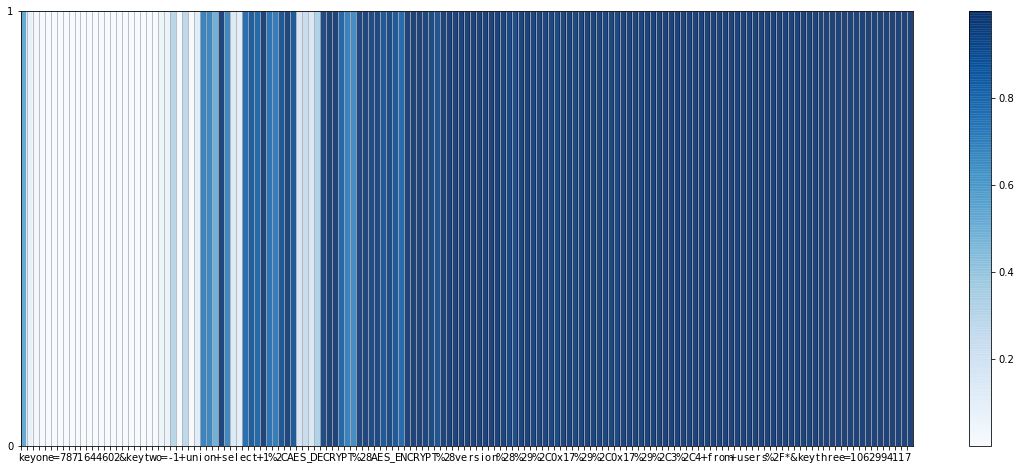

In [61]:
import matplotlib.pyplot as plt

plt.figure()
fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
heatmap = ax.pcolor(heatmap_y, cmap=plt.cm.Blues, alpha=0.9)
plt.colorbar(heatmap)

xticks = range(0,len(heatmap_x))
ax.set_xticks(xticks, minor=False) # major ticks
ax.set_xticklabels(heatmap_x, minor = False, rotation=0)   # labels should be 'unicode'

yticks = range(0,2)
ax.set_yticks(yticks, minor=False)
# ax.set_yticklabels(heatmap_x, minor = False, rotation=0)   # labels should be 'unicode'
# ax.set_yticklabels(Y_label, minor = False)   # labels should be 'unicode'

ax.grid(True)

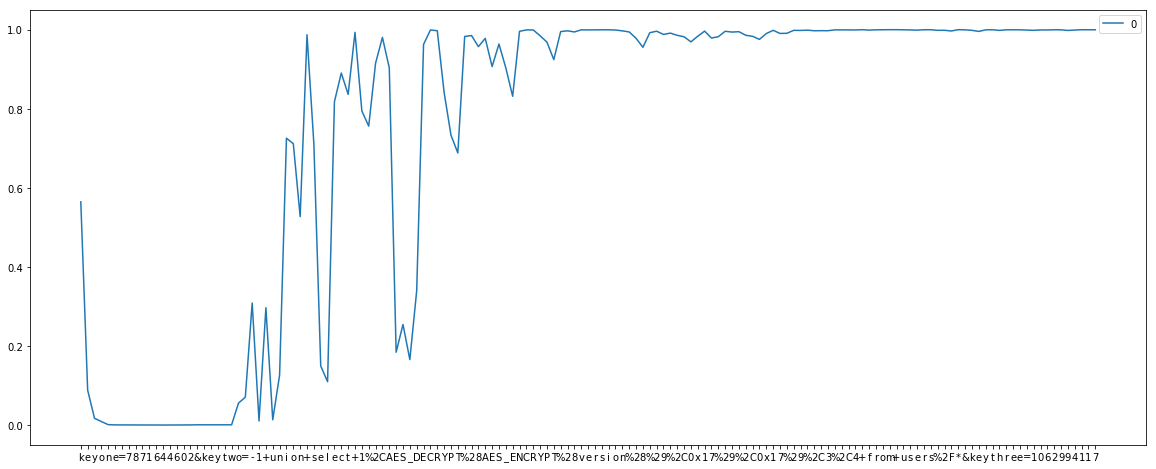

In [62]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
for i in range(1):
    plt.plot(heatmap_y[i][:len(heatmap_x)], label=str(i))
xticks = range(0,len(heatmap_x))
ax.set_xticks(xticks) # major ticks
ax.set_xticklabels(heatmap_x)   # labels should be 'unicode'
plt.legend(loc='upper right')
plt.show()